# Report Checker

This notebook checks and validates all reports from the model run.

## Overview
- Load and validate all JSON reports
- Check data quality and consistency
- Display metrics and validation results
- Visualize key information

In [1]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Get project root (one level up from notebooks/)
# This works whether notebook is run from notebooks/ or project root
current_dir = Path.cwd()

# Check if we're in notebooks directory
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
elif (current_dir / 'reports').exists():
    # Already at project root
    project_root = current_dir
else:
    # Try going up one level
    project_root = current_dir.parent

# Get reports directory
reports_dir = project_root / "reports"
reports_dir.mkdir(parents=True, exist_ok=True)

print(f"Current directory: {current_dir.absolute()}")
print(f"Project root: {project_root.absolute()}")
print(f"Reports directory: {reports_dir.absolute()}")
print(f"Reports directory exists: {reports_dir.exists()}")

Current directory: /Users/jlb/Documents/Python Course/0_OSE_PJT/FULL OSEK/PLUG TEST/_OUTPUT_PROJECT_V07/ose-v4/notebooks
Project root: /Users/jlb/Documents/Python Course/0_OSE_PJT/FULL OSEK/PLUG TEST/_OUTPUT_PROJECT_V07/ose-v4
Reports directory: /Users/jlb/Documents/Python Course/0_OSE_PJT/FULL OSEK/PLUG TEST/_OUTPUT_PROJECT_V07/ose-v4/reports
Reports directory exists: True


## 1. Load All Reports

In [2]:
# Load all JSON reports
reports = {}

# Current report filenames (v07)
json_files = [
    "run_manifest.json",
    "metrics.json",
    "feature_selection.json",
    "feature_policy.json",
    "kept_features.json",
    "missing_summary.json",
    "window_validation.json",
    "text_ablation.json",
]

for json_file in json_files:
    file_path = reports_dir / json_file
    if file_path.exists():
        with open(file_path, 'r') as f:
            reports[json_file.replace('.json', '')] = json.load(f)
        print(f"✓ Loaded {json_file}")
    else:
        print(f"✗ Missing {json_file}")

print(f"\nLoaded {len(reports)} reports")

✓ Loaded run_manifest.json
✓ Loaded metrics.json
✓ Loaded feature_selection.json
✓ Loaded feature_policy.json
✓ Loaded kept_features.json
✓ Loaded missing_summary.json
✓ Loaded window_validation.json
✓ Loaded text_ablation.json

Loaded 8 reports


## 2. Run Manifest Summary

In [3]:
if 'run_manifest' in reports:
    manifest = reports['run_manifest']
    
    display(Markdown("### Run Configuration"))
    print(f"**Version:** {manifest.get('version', 'N/A')}")
    print(f"**Seed:** {manifest.get('seed', 'N/A')}")
    print(f"**Timestamp:** {manifest.get('timestamp', 'N/A')}")
    
    display(Markdown("\n### Temporal Windows"))
    temporal = manifest.get('temporal_windows', {})
    for key, value in temporal.items():
        print(f"- **{key}:** {value}")
    
    display(Markdown("\n### Model Configuration"))
    model = manifest.get('model', {})
    print(f"- **Type:** {model.get('type', 'N/A')}")
    print(f"- **Calibration:** {model.get('calibration', 'N/A')}")
    print(f"- **Random State:** {model.get('random_state', 'N/A')}")
    
    display(Markdown("\n### Feature Policy"))
    feature_policy = manifest.get('feature_policy', {})
    print(f"- **Steps:** {', '.join(feature_policy.get('steps', []))}")
    print(f"- **Max Features:** {feature_policy.get('max_features', 'N/A')}")
    print(f"- **Text Max %:** {feature_policy.get('text_max_pct', 'N/A')}")
else:
    print("⚠ Run manifest not found")

### Run Configuration

**Version:** current
**Seed:** 42
**Timestamp:** 2025-12-09T17:23:40.375661



### Temporal Windows

- **t0:** 2023-01-01
- **t1:** 2024-01-01
- **feature_window:** < 2023-01-01
- **label_window:** [2023-01-01 → 2024-01-01]



### Model Configuration

- **Type:** XGBoost + CalibratedClassifierCV
- **Calibration:** isotonic (cv=3)
- **Random State:** 42



### Feature Policy

- **Steps:** drop_label_cousins, drop_high_missing_50pct, add_pca10_text, model_based_selection, cap_text_30pct
- **Max Features:** 200
- **Text Max %:** 0.3


## 3. Model Metrics

### Performance Metrics

,Value
accuracy,0.6968
precision,0.7817
recall,0.8449
f1_score,0.8121
roc_auc,0.5561
pr_auc,0.8019
brier_score,0.1989


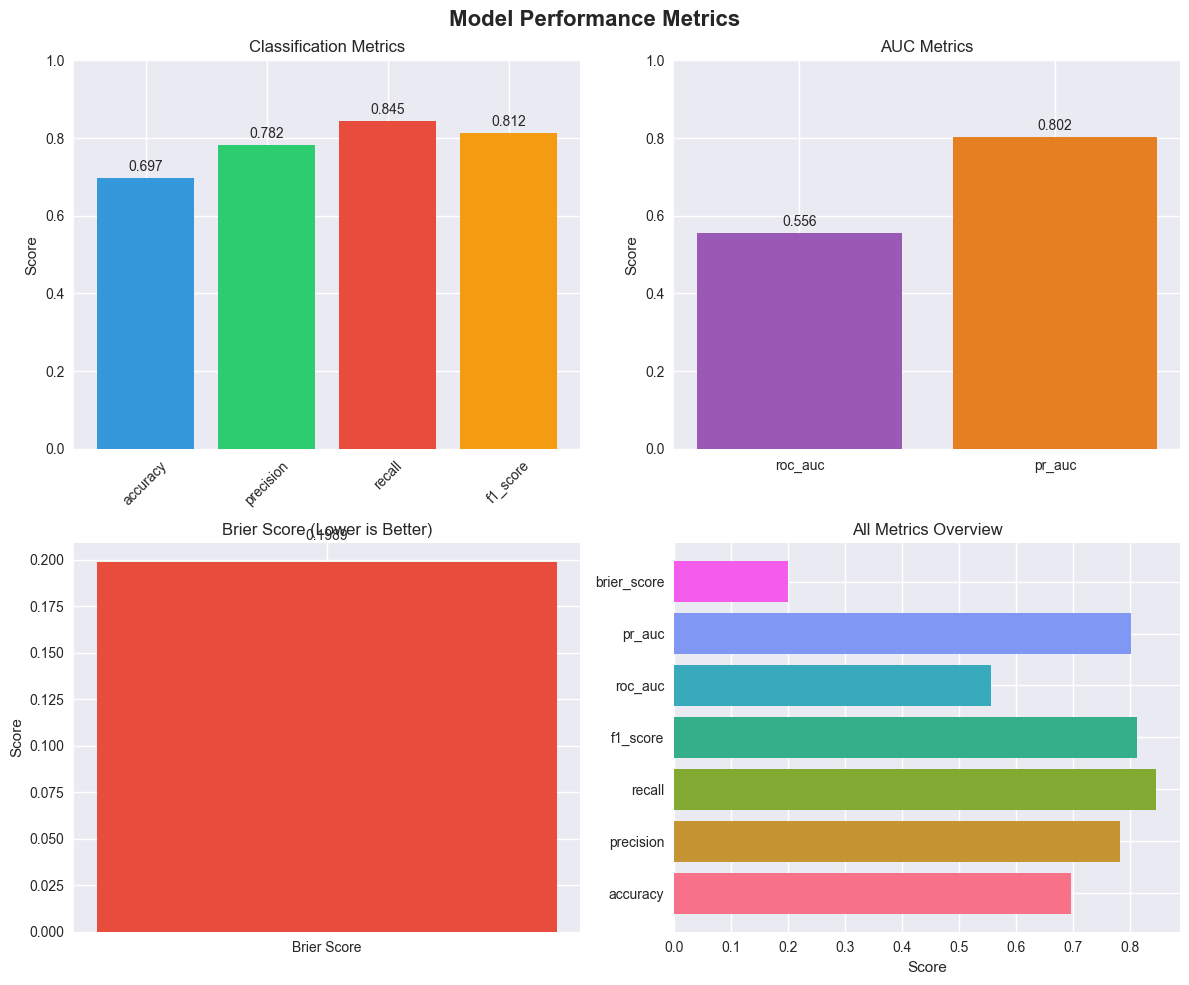

### Performance Assessment

✗ ROC AUC is low (< 0.6)
✓ PR AUC is good (> 0.75)
✓ Brier Score is good (< 0.25)


In [4]:
if 'metrics' in reports:
    metrics = reports['metrics']
    
    # Create metrics DataFrame
    metrics_df = pd.DataFrame([metrics]).T
    metrics_df.columns = ['Value']
    metrics_df = metrics_df.round(4)
    
    display(Markdown("### Performance Metrics"))
    display(metrics_df)
    
    # Visualize metrics
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Model Performance Metrics', fontsize=16, fontweight='bold')
    
    # Accuracy, Precision, Recall, F1
    classification_metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    values = [metrics.get(m, 0) for m in classification_metrics]
    axes[0, 0].bar(classification_metrics, values, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
    axes[0, 0].set_title('Classification Metrics')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(values):
        axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # ROC AUC and PR AUC
    auc_metrics = ['roc_auc', 'pr_auc']
    auc_values = [metrics.get(m, 0) for m in auc_metrics]
    axes[0, 1].bar(auc_metrics, auc_values, color=['#9b59b6', '#e67e22'])
    axes[0, 1].set_title('AUC Metrics')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_ylim(0, 1)
    for i, v in enumerate(auc_values):
        axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # Brier Score
    brier = metrics.get('brier_score', 0)
    axes[1, 0].bar(['Brier Score'], [brier], color='#e74c3c')
    axes[1, 0].set_title('Brier Score (Lower is Better)')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].text(0, brier + 0.01, f'{brier:.4f}', ha='center', va='bottom')
    
    # All metrics comparison
    all_metrics = list(metrics.keys())
    all_values = [metrics[m] for m in all_metrics]
    axes[1, 1].barh(all_metrics, all_values, color=sns.color_palette("husl", len(all_metrics)))
    axes[1, 1].set_title('All Metrics Overview')
    axes[1, 1].set_xlabel('Score')
    
    plt.tight_layout()
    plt.show()
    
    # Summary assessment
    display(Markdown("### Performance Assessment"))
    if metrics.get('roc_auc', 0) > 0.7:
        print("✓ ROC AUC is good (> 0.7)")
    elif metrics.get('roc_auc', 0) > 0.6:
        print("⚠ ROC AUC is moderate (0.6-0.7)")
    else:
        print("✗ ROC AUC is low (< 0.6)")
    
    if metrics.get('pr_auc', 0) > 0.75:
        print("✓ PR AUC is good (> 0.75)")
    elif metrics.get('pr_auc', 0) > 0.65:
        print("⚠ PR AUC is moderate (0.65-0.75)")
    else:
        print("✗ PR AUC is low (< 0.65)")
    
    if metrics.get('brier_score', 1) < 0.25:
        print("✓ Brier Score is good (< 0.25)")
    else:
        print("⚠ Brier Score could be improved")
else:
    print("⚠ Metrics not found")

## 4. Feature Selection Analysis

### Feature Selection Pipeline

- **Original Features:** 122
- **After Drop Cousins:** 95
- **After Drop Missing:** 122
- **Selected Features:** 86
- **Text Features:** 10
- **Tabular Features:** 76
- **Text Percentage:** 11.63%


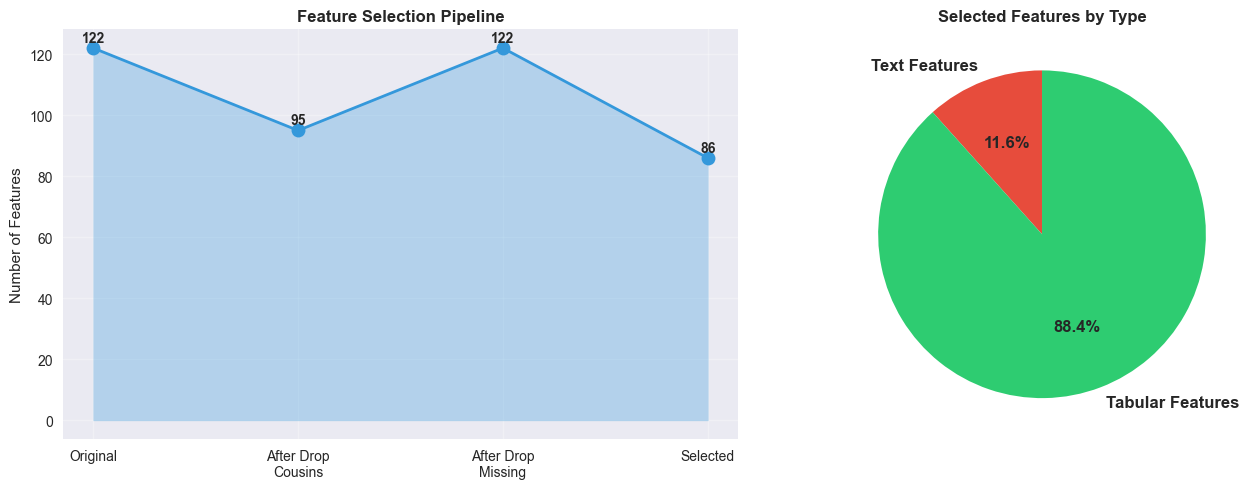


### Selected Features (86 total)


**Text Features (10):**
text_pca_0, text_pca_1, text_pca_2, text_pca_3, text_pca_4, text_pca_5, text_pca_6, text_pca_7, text_pca_8, text_pca_9

**Tabular Features (76):**
annee, annee_was_nan, appartient_groupe, ca_bilan, ca_bilan_was_nan, cac40, capital_social, capital_social_was_nan, charges_financieres, charges_financieres_was_nan, dateConsolide_was_nan, date_cloture_exercice_was_nan, dotations_amortissements, dotations_amortissements_was_nan, duree_exercice, duree_exercice_was_nan, effectif, effectifConsolide, effectifConsolide_was_nan, effectifEstime, effectifEstime_was_nan, effectifGroupe, effectifGroupe_was_nan, effectif_sous_traitance, effectif_sous_traitance_was_nan, effectif_was_nan, effectif_workforce, effectif_workforce_was_nan, entreprise_b2b, entreprise_b2c, entreprise_familiale, evolution_effectif, evolution_effectif_was_nan, filtre_levee_fond, flag_type_entreprise_was_nan, fonds_propres, fonds_propres_was_nan, hasESV1Contacts, hasGroupOwner, hasMarques, impots_taxes, i

In [5]:
if 'feature_selection' in reports:
    feat_sel = reports['feature_selection']
    
    display(Markdown("### Feature Selection Pipeline"))
    print(f"- **Original Features:** {feat_sel.get('original_features', 'N/A')}")
    print(f"- **After Drop Cousins:** {feat_sel.get('after_drop_cousins', 'N/A')}")
    print(f"- **After Drop Missing:** {feat_sel.get('after_drop_missing', 'N/A')}")
    print(f"- **Selected Features:** {feat_sel.get('selected_features', 'N/A')}")
    print(f"- **Text Features:** {feat_sel.get('text_features', 'N/A')}")
    print(f"- **Tabular Features:** {feat_sel.get('tabular_features', 'N/A')}")
    print(f"- **Text Percentage:** {feat_sel.get('text_percentage', 'N/A'):.2f}%")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Feature reduction pipeline
    pipeline_steps = ['Original', 'After Drop\nCousins', 'After Drop\nMissing', 'Selected']
    pipeline_counts = [
        feat_sel.get('original_features', 0),
        feat_sel.get('after_drop_cousins', 0),
        feat_sel.get('after_drop_missing', 0),
        feat_sel.get('selected_features', 0)
    ]
    
    axes[0].plot(pipeline_steps, pipeline_counts, marker='o', linewidth=2, markersize=10, color='#3498db')
    axes[0].fill_between(pipeline_steps, pipeline_counts, alpha=0.3, color='#3498db')
    axes[0].set_title('Feature Selection Pipeline', fontweight='bold')
    axes[0].set_ylabel('Number of Features')
    axes[0].grid(True, alpha=0.3)
    for i, (step, count) in enumerate(zip(pipeline_steps, pipeline_counts)):
        axes[0].text(i, count + 1, str(count), ha='center', va='bottom', fontweight='bold')
    
    # Feature type distribution
    feature_types = ['Text Features', 'Tabular Features']
    feature_counts = [
        feat_sel.get('text_features', 0),
        feat_sel.get('tabular_features', 0)
    ]
    colors = ['#e74c3c', '#2ecc71']
    
    axes[1].pie(feature_counts, labels=feature_types, autopct='%1.1f%%', 
                startangle=90, colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})
    axes[1].set_title('Selected Features by Type', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Selected features list
    selected_features = feat_sel.get('selected_feature_names', [])
    display(Markdown(f"\n### Selected Features ({len(selected_features)} total)"))
    
    # Separate text and tabular features
    text_features = [f for f in selected_features if f.startswith('text_pca')]
    tabular_features = [f for f in selected_features if not f.startswith('text_pca')]
    
    print(f"\n**Text Features ({len(text_features)}):**")
    print(', '.join(sorted(text_features)))
    
    print(f"\n**Tabular Features ({len(tabular_features)}):**")
    print(', '.join(sorted(tabular_features)))
else:
    print("⚠ Feature selection report not found")

## 5. Window Validation Checks

### Temporal Windows

- **t0:** 2023-01-01 00:00:00
- **t1:** 2024-01-01 00:00:00
- **Feature Window:** < 2023-01-01 00:00:00
- **Label Window:** [2023-01-01 00:00:00 → 2024-01-01 00:00:00]



### Validation Checks

  **max_feature_article_date:** 2022-12-30 23:00:00
✓ **feature_articles_before_t0:** True
  **max_feature_signal_date:** 2022-12-30 23:00:00
✓ **feature_signals_before_t0:** True
  **min_label_date:** 2023-01-01 23:00:00
  **max_label_date:** 2023-12-31 23:00:00
✓ **labels_in_window:** True



### Sample Counts

- **feature_companies:** 5,434
- **label_companies:** 2,573
- **feature_articles:** 23,414
- **label_articles:** 4,461
- **feature_signals:** 38,728



### Leak Checks

✓ **no_feature_dates_after_t0:** True
✓ **no_label_dates_before_t0:** True
✓ **no_label_dates_after_t1:** True


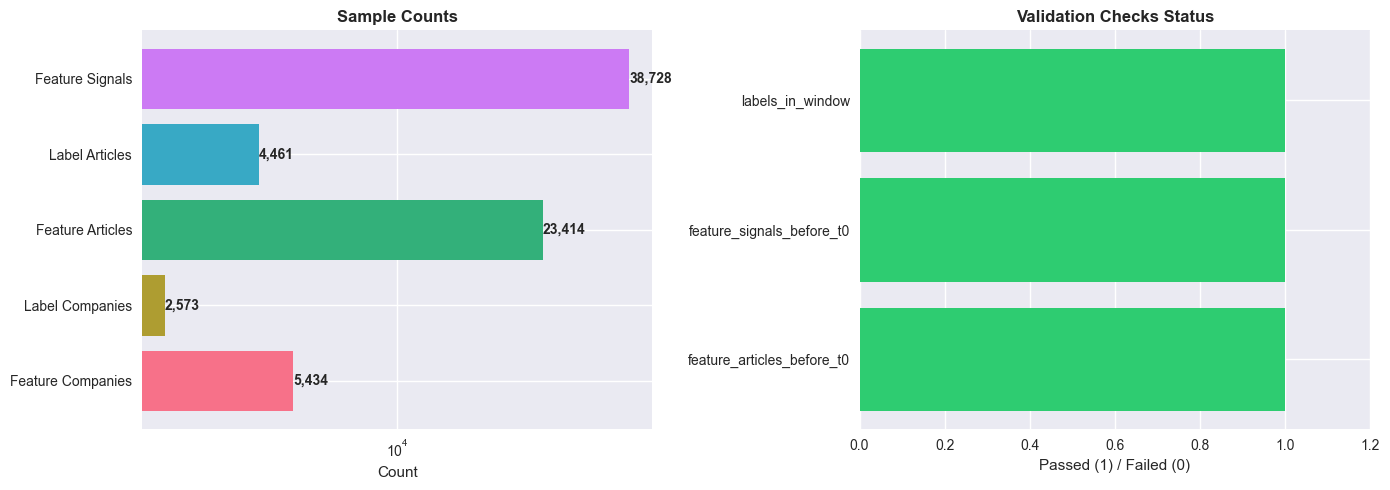

### Overall Validation Assessment

✓ All validation checks passed!


In [6]:
if 'window_validation' in reports:
    validation = reports['window_validation']
    
    display(Markdown("### Temporal Windows"))
    print(f"- **t0:** {validation.get('t0', 'N/A')}")
    print(f"- **t1:** {validation.get('t1', 'N/A')}")
    print(f"- **Feature Window:** {validation.get('feature_window', 'N/A')}")
    print(f"- **Label Window:** {validation.get('label_window', 'N/A')}")
    
    display(Markdown("\n### Validation Checks"))
    val_checks = validation.get('validation_checks', {})
    all_passed = True
    for check, result in val_checks.items():
        status = "✓" if result else "✗"
        if isinstance(result, bool):
            print(f"{status} **{check}:** {result}")
            if not result:
                all_passed = False
        else:
            print(f"  **{check}:** {result}")
    
    display(Markdown("\n### Sample Counts"))
    sample_counts = validation.get('sample_counts', {})
    for key, value in sample_counts.items():
        print(f"- **{key}:** {value:,}")
    
    display(Markdown("\n### Leak Checks"))
    leak_checks = validation.get('leak_checks', {})
    all_leak_checks_passed = True
    for check, result in leak_checks.items():
        status = "✓" if result else "✗"
        print(f"{status} **{check}:** {result}")
        if not result:
            all_leak_checks_passed = False
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Sample counts
    sample_labels = [k.replace('_', ' ').title() for k in sample_counts.keys()]
    sample_values = list(sample_counts.values())
    
    axes[0].barh(sample_labels, sample_values, color=sns.color_palette("husl", len(sample_labels)))
    axes[0].set_title('Sample Counts', fontweight='bold')
    axes[0].set_xlabel('Count')
    axes[0].set_xscale('log')
    for i, v in enumerate(sample_values):
        axes[0].text(v, i, f'{v:,}', va='center', ha='left', fontweight='bold')
    
    # Validation status
    check_names = list(val_checks.keys())
    check_results = [1 if v else 0 for v in val_checks.values() if isinstance(v, bool)]
    check_names_bool = [k for k, v in val_checks.items() if isinstance(v, bool)]
    
    colors = ['#2ecc71' if r else '#e74c3c' for r in check_results]
    axes[1].barh(check_names_bool, check_results, color=colors)
    axes[1].set_title('Validation Checks Status', fontweight='bold')
    axes[1].set_xlabel('Passed (1) / Failed (0)')
    axes[1].set_xlim(0, 1.2)
    
    plt.tight_layout()
    plt.show()
    
    # Overall assessment
    display(Markdown("### Overall Validation Assessment"))
    if all_passed and all_leak_checks_passed:
        print("✓ All validation checks passed!")
    else:
        print("✗ Some validation checks failed - review needed")
else:
    print("⚠ Window validation report not found")

## 6. Missing Data Analysis

### Data Shape Changes

**Before:** 5,434 rows × 81 columns
**After:** 5,434 rows × 87 columns
**Rows Dropped:** 0
**Columns Dropped:** -6



### Missing Data Before Processing


Columns with missing data (43):


,column,n_missing,pct_missing
40,caGroupe,5434,100.000000
24,code_confidentialite,5434,100.000000
63,fintech,5434,100.000000
53,nbMarques,5434,100.000000
51,nbFilialesDirectes,5434,100.000000
48,effectifGroupe,5434,100.000000
47,effectifEstime,5434,100.000000
46,effectifConsolide,5434,100.000000
36,resultat_net_consolide,5344,98.343762
39,caConsolide,5340,98.270151



### Missing Data After Processing


Columns with missing data (24):


,column,n_missing,pct_missing
31,nbMarques,5434,100.000000
29,nbFilialesDirectes,5434,100.000000
13,dotations_amortissements,2666,49.061465
8,salaires_traitements,2630,48.398969
9,charges_financieres,2621,48.233346
10,impots_taxes,2614,48.104527
12,resultat_exploitation,2546,46.853147
21,resultatExploitation,2546,46.853147
5,fonds_propres,1874,34.486566
15,resultat_bilan,1785,32.848730



### Dropped Columns (12)

ca_france, code_confidentialite, filiales_participations, evolution_ca, subventions_investissements, ca_export, participation_bilan, ca_consolide, resultat_net_consolide, caConsolide, caGroupe, fintech



### Missing Flags Created (31)

effectif_was_nan, effectif_sous_traitance_was_nan, evolution_effectif_was_nan, effectif_workforce_was_nan, effectifConsolide_was_nan, effectifEstime_was_nan, effectifGroupe_was_nan, nbFilialesDirectes_was_nan, nbMarques_was_nan, siret_kpi_was_nan, year_was_nan, fonds_propres_was_nan, date_cloture_exercice_was_nan, duree_exercice_was_nan, salaires_traitements_was_nan, charges_financieres_was_nan, impots_taxes_was_nan, ca_bilan_was_nan, resultat_exploitation_was_nan, dotations_amortissements_was_nan, capital_social_was_nan, resultat_bilan_was_nan, annee_was_nan, siret_financial_was_nan, resultatExploitation_was_nan, dateConsolide_was_nan, siret_workforce_was_nan, siret_structure_was_nan, siret_flags_was_nan, flag_type_entreprise_was_nan, siret_contact_was_nan


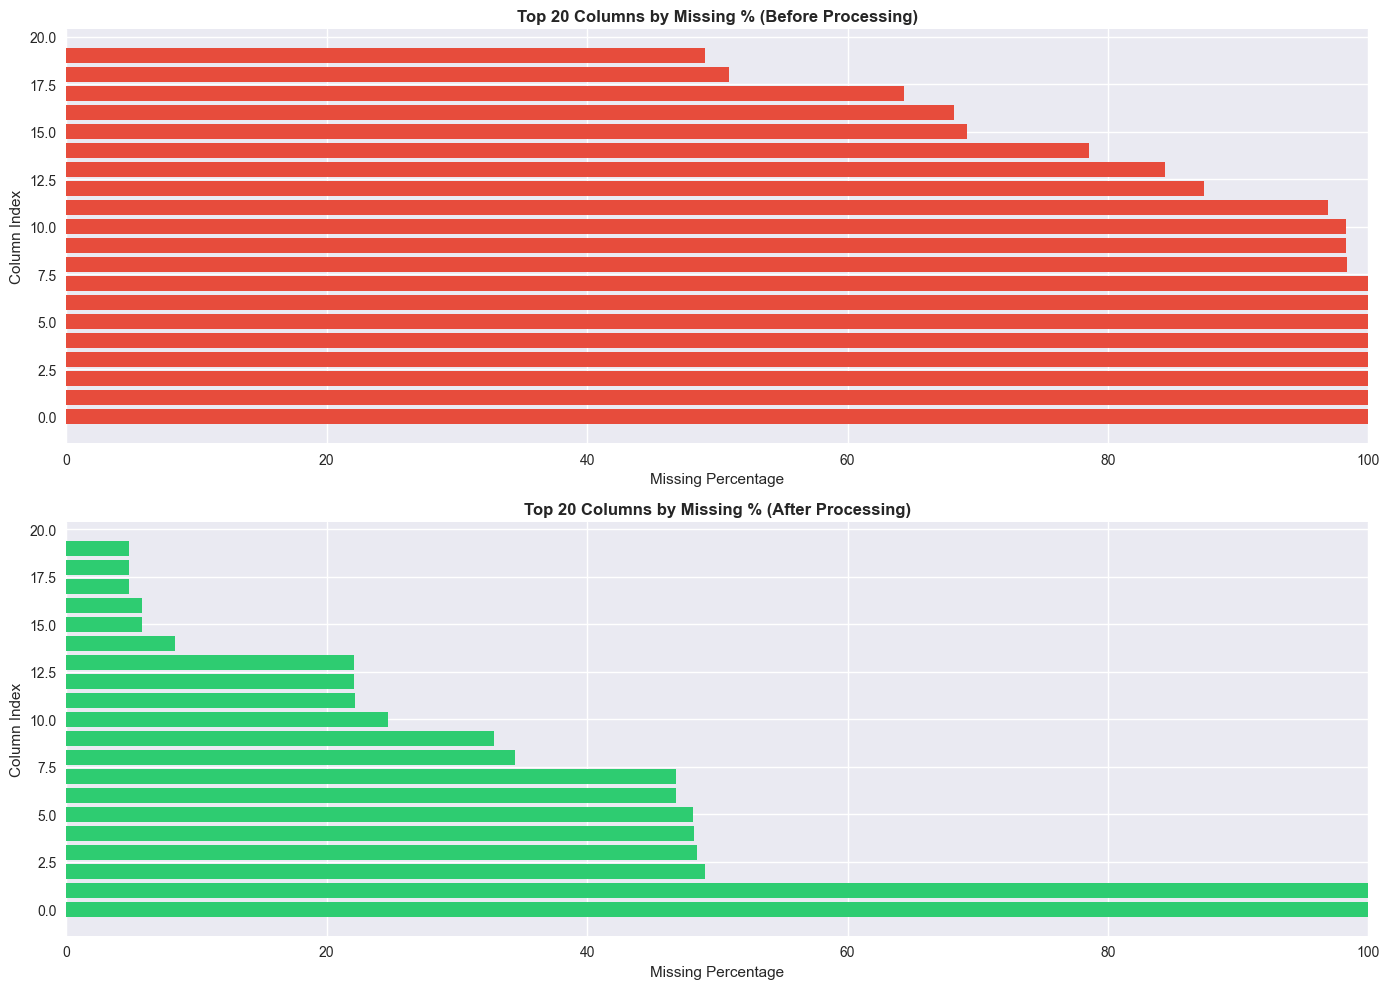

In [7]:
if 'missing_summary' in reports:
    missing = reports['missing_summary']
    
    display(Markdown("### Data Shape Changes"))
    before = missing.get('before', {})
    after = missing.get('after', {})
    
    print(f"**Before:** {before.get('n_rows', 'N/A'):,} rows × {before.get('n_cols', 'N/A')} columns")
    print(f"**After:** {after.get('n_rows', 'N/A'):,} rows × {after.get('n_cols', 'N/A')} columns")
    print(f"**Rows Dropped:** {before.get('n_rows', 0) - after.get('n_rows', 0):,}")
    print(f"**Columns Dropped:** {before.get('n_cols', 0) - after.get('n_cols', 0)}")
    
    # Missing data before
    display(Markdown("\n### Missing Data Before Processing"))
    missing_before = before.get('missing_by_column', {})
    if missing_before:
        missing_df_before = pd.DataFrame([
            {'column': k, 'n_missing': v['n_missing'], 'pct_missing': v['pct_missing']}
            for k, v in missing_before.items()
        ]).sort_values('pct_missing', ascending=False)
        
        # Show columns with missing data
        missing_cols_before = missing_df_before[missing_df_before['pct_missing'] > 0]
        if len(missing_cols_before) > 0:
            print(f"\nColumns with missing data ({len(missing_cols_before)}):")
            display(missing_df_before.head(20))
        else:
            print("No missing data found")
    
    # Missing data after
    display(Markdown("\n### Missing Data After Processing"))
    missing_after = after.get('missing_by_column', {})
    if missing_after:
        missing_df_after = pd.DataFrame([
            {'column': k, 'n_missing': v['n_missing'], 'pct_missing': v['pct_missing']}
            for k, v in missing_after.items()
        ]).sort_values('pct_missing', ascending=False)
        
        # Show columns with missing data
        missing_cols_after = missing_df_after[missing_df_after['pct_missing'] > 0]
        if len(missing_cols_after) > 0:
            print(f"\nColumns with missing data ({len(missing_cols_after)}):")
            display(missing_cols_after)
        else:
            print("No missing data found")
    
    # Dropped columns
    dropped_cols = missing.get('dropped_columns', [])
    display(Markdown(f"\n### Dropped Columns ({len(dropped_cols)})"))
    if dropped_cols:
        print(', '.join(dropped_cols))
    
    # Missing flags created
    missing_flags = missing.get('missing_flags_created', [])
    display(Markdown(f"\n### Missing Flags Created ({len(missing_flags)})"))
    if missing_flags:
        print(', '.join(missing_flags))
    
    # Visualization
    if missing_before and missing_after:
        fig, axes = plt.subplots(2, 1, figsize=(14, 10))
        
        # Before processing
        missing_pct_before = [v['pct_missing'] for v in missing_before.values() if v['pct_missing'] > 0]
        missing_pct_before = sorted(missing_pct_before, reverse=True)[:20]  # Top 20
        
        axes[0].barh(range(len(missing_pct_before)), missing_pct_before, color='#e74c3c')
        axes[0].set_title('Top 20 Columns by Missing % (Before Processing)', fontweight='bold')
        axes[0].set_xlabel('Missing Percentage')
        axes[0].set_ylabel('Column Index')
        axes[0].set_xlim(0, 100)
        
        # After processing
        missing_pct_after = [v['pct_missing'] for v in missing_after.values() if v['pct_missing'] > 0]
        missing_pct_after = sorted(missing_pct_after, reverse=True)[:20]  # Top 20
        
        if missing_pct_after:
            axes[1].barh(range(len(missing_pct_after)), missing_pct_after, color='#2ecc71')
            axes[1].set_title('Top 20 Columns by Missing % (After Processing)', fontweight='bold')
            axes[1].set_xlabel('Missing Percentage')
            axes[1].set_ylabel('Column Index')
            axes[1].set_xlim(0, 100)
        else:
            axes[1].text(0.5, 0.5, 'No missing data after processing', 
                        ha='center', va='center', fontsize=14, fontweight='bold')
            axes[1].set_title('Missing Data After Processing', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
else:
    print("⚠ Missing summary report not found")

## 7. Text Ablation Study

### Ablation Study Results

,Model Type,ROC AUC,PR AUC,N Features,N Text,N Tabular
0,Text Only,0.5203,0.7836,10,0,0
1,Tabular Only,0.5400,0.7970,37,0,0
2,Full,0.5493,0.8008,47,10,37


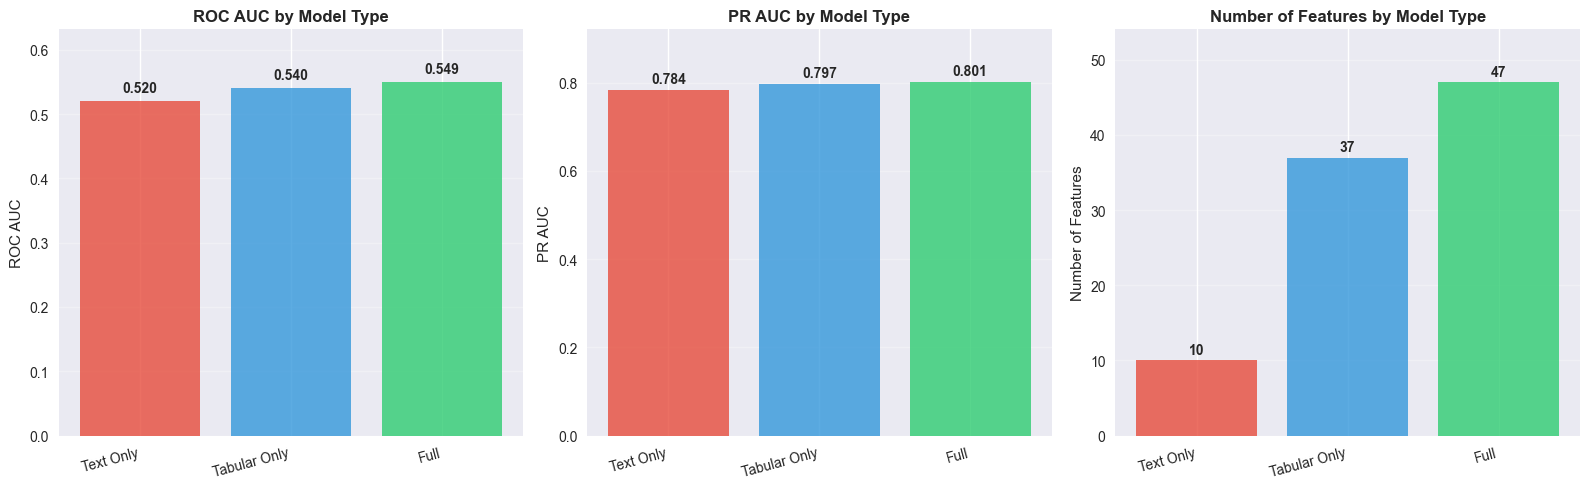

### Ablation Analysis

✓ Full model performs best (ROC AUC improvement: 0.0093)
⚠ Tabular features outperform text features (ROC AUC: 0.5400 vs 0.5203)


In [8]:
if 'text_ablation' in reports:
    ablation = reports['text_ablation']
    
    display(Markdown("### Ablation Study Results"))
    
    # Create comparison DataFrame
    ablation_data = []
    for model_type, metrics in ablation.items():
        ablation_data.append({
            'Model Type': model_type.replace('_', ' ').title(),
            'ROC AUC': metrics.get('roc_auc', 0),
            'PR AUC': metrics.get('pr_auc', 0),
            'N Features': metrics.get('n_features', 0),
            'N Text': metrics.get('n_text', 0),
            'N Tabular': metrics.get('n_tabular', 0)
        })
    
    ablation_df = pd.DataFrame(ablation_data)
    display(ablation_df.round(4))
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    model_types = ablation_df['Model Type'].values
    x_pos = np.arange(len(model_types))
    
    # ROC AUC comparison
    roc_aucs = ablation_df['ROC AUC'].values
    axes[0].bar(x_pos, roc_aucs, color=['#e74c3c', '#3498db', '#2ecc71'], alpha=0.8)
    axes[0].set_title('ROC AUC by Model Type', fontweight='bold')
    axes[0].set_ylabel('ROC AUC')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(model_types, rotation=15, ha='right')
    axes[0].set_ylim(0, max(roc_aucs) * 1.15)
    axes[0].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(roc_aucs):
        axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # PR AUC comparison
    pr_aucs = ablation_df['PR AUC'].values
    axes[1].bar(x_pos, pr_aucs, color=['#e74c3c', '#3498db', '#2ecc71'], alpha=0.8)
    axes[1].set_title('PR AUC by Model Type', fontweight='bold')
    axes[1].set_ylabel('PR AUC')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(model_types, rotation=15, ha='right')
    axes[1].set_ylim(0, max(pr_aucs) * 1.15)
    axes[1].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(pr_aucs):
        axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Feature count comparison
    n_features = ablation_df['N Features'].values
    axes[2].bar(x_pos, n_features, color=['#e74c3c', '#3498db', '#2ecc71'], alpha=0.8)
    axes[2].set_title('Number of Features by Model Type', fontweight='bold')
    axes[2].set_ylabel('Number of Features')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(model_types, rotation=15, ha='right')
    axes[2].set_ylim(0, max(n_features) * 1.15)
    axes[2].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(n_features):
        axes[2].text(i, v + 0.5, str(int(v)), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Analysis
    display(Markdown("### Ablation Analysis"))
    full_roc = ablation.get('full', {}).get('roc_auc', 0)
    text_roc = ablation.get('text_only', {}).get('roc_auc', 0)
    tabular_roc = ablation.get('tabular_only', {}).get('roc_auc', 0)
    
    if full_roc > max(text_roc, tabular_roc):
        improvement = full_roc - max(text_roc, tabular_roc)
        print(f"✓ Full model performs best (ROC AUC improvement: {improvement:.4f})")
    else:
        print("⚠ Full model does not outperform individual feature types")
    
    if text_roc > tabular_roc:
        print(f"✓ Text features outperform tabular features (ROC AUC: {text_roc:.4f} vs {tabular_roc:.4f})")
    else:
        print(f"⚠ Tabular features outperform text features (ROC AUC: {tabular_roc:.4f} vs {text_roc:.4f})")
else:
    print("⚠ Text ablation report not found")

## 8. Feature Policy

In [9]:
if 'feature_policy' in reports:
    policy = reports['feature_policy']
    
    display(Markdown("### Feature Processing Steps"))
    steps = policy.get('steps', [])
    for i, step in enumerate(steps, 1):
        print(f"{i}. {step}")
    
    display(Markdown("\n### Policy Parameters"))
    params = policy.get('parameters', {})
    for key, value in params.items():
        print(f"- **{key}:** {value}")
    
    display(Markdown("\n### Dropped Features"))
    dropped_cousins = policy.get('dropped_cousins', [])
    dropped_missing = policy.get('dropped_missing', [])
    
    if dropped_cousins:
        print(f"**Dropped Cousins ({len(dropped_cousins)}):** {', '.join(dropped_cousins)}")
    else:
        print("**Dropped Cousins:** None")
    
    if dropped_missing:
        print(f"**Dropped High Missing ({len(dropped_missing)}):** {', '.join(dropped_missing)}")
    else:
        print("**Dropped High Missing:** None")
else:
    print("⚠ Feature policy report not found")

### Feature Processing Steps

1. drop_label_cousins
2. drop_high_missing_50pct
3. add_pca20_text
4. model_based_selection
5. cap_text_30pct



### Policy Parameters

- **max_features:** 200
- **text_max_pct:** 0.3
- **missing_threshold:** 0.5



### Dropped Features

**Dropped Cousins:** None
**Dropped High Missing (27):** nbFilialesDirectes, nbMarques, financial_score_last, growth_score_last, profit_score_last, ca_growth_last, effectif_growth_last, margin_norm_last, capital_ratio_last, financial_year_last, financial_score_3y_mean, growth_score_3y_mean, profit_score_3y_mean, signal_score, decidento_base_score, decidento_score, OSE_score, signal_B_count, signal_W_count, signal_E_count, signal_F_count, signal_N_count, signal_S_count, signal_K1_count, signal_I_count, signal_M_count, signal_O_count


## 9. Consistency Checks

In [10]:
display(Markdown("### Cross-Report Consistency Validation"))

issues = []

# feature selection
if 'run_manifest' in reports and 'feature_selection' in reports:
    manifest_feat = reports['run_manifest'].get('feature_selection', {})
    feat_sel = reports['feature_selection']
    
    # Check feature counts
    if manifest_feat.get('selected_features') != feat_sel.get('selected_features'):
        issues.append("⚠ Feature count mismatch between manifest and feature_selection")
    else:
        print("✓ Feature counts match between reports")
    
    # Check feature names
    manifest_names = set(manifest_feat.get('selected_feature_names', []))
    feat_sel_names = set(feat_sel.get('selected_feature_names', []))
    if manifest_names != feat_sel_names:
        issues.append("⚠ Feature names mismatch between manifest and feature_selection")
    else:
        print("✓ Feature names match between reports")

# window validation
if 'run_manifest' in reports and 'window_validation' in reports:
    manifest_val = reports['run_manifest'].get('validation', {})
    window_val = reports['window_validation']
    
    if manifest_val.get('t0') != window_val.get('t0'):
        issues.append("⚠ t0 mismatch between reports")
    else:
        print("✓ t0 matches between reports")
    
    if manifest_val.get('t1') != window_val.get('t1'):
        issues.append("⚠ t1 mismatch between reports")
    else:
        print("✓ t1 matches between reports")

# feature policy
if 'run_manifest' in reports and 'feature_policy' in reports:
    manifest_policy = reports['run_manifest'].get('feature_policy', {})
    policy = reports['feature_policy']
    
    manifest_steps = manifest_policy.get('steps', [])
    policy_steps = policy.get('steps', [])
    
    if manifest_steps != policy_steps:
        issues.append("⚠ Feature policy steps mismatch between reports")
    else:
        print("✓ Feature policy steps match between reports")

# summary
if issues:
    display(Markdown("\n### ⚠ Issues Found"))
    for issue in issues:
        print(issue)
else:
    display(Markdown("\n### ✓ All Consistency Checks Passed"))

### Cross-Report Consistency Validation

✓ Feature counts match between reports
✓ Feature names match between reports
✓ t0 matches between reports
✓ t1 matches between reports



### ⚠ Issues Found

⚠ Feature policy steps mismatch between reports


## 10. Summary Report

In [11]:
display(Markdown("### Overall Summary"))

summary_data = []

# Model performance
if 'metrics' in reports:
    metrics = reports['metrics']
    summary_data.append(['Model Performance', 'ROC AUC', f"{metrics.get('roc_auc', 0):.4f}"])
    summary_data.append(['Model Performance', 'PR AUC', f"{metrics.get('pr_auc', 0):.4f}"])
    summary_data.append(['Model Performance', 'F1 Score', f"{metrics.get('f1_score', 0):.4f}"])

# Feature selection
if 'feature_selection' in reports:
    feat_sel = reports['feature_selection']
    summary_data.append(['Feature Selection', 'Total Features', str(feat_sel.get('selected_features', 0))])
    summary_data.append(['Feature Selection', 'Text Features', str(feat_sel.get('text_features', 0))])
    summary_data.append(['Feature Selection', 'Tabular Features', str(feat_sel.get('tabular_features', 0))])

# Validation
if 'window_validation' in reports:
    validation = reports['window_validation']
    val_checks = validation.get('validation_checks', {})
    passed_checks = sum(1 for v in val_checks.values() if isinstance(v, bool) and v)
    total_checks = sum(1 for v in val_checks.values() if isinstance(v, bool))
    summary_data.append(['Validation', 'Checks Passed', f"{passed_checks}/{total_checks}"])

# Data quality
if 'missing_summary' in reports:
    missing = reports['missing_summary']
    before = missing.get('before', {})
    after = missing.get('after', {})
    summary_data.append(['Data Quality', 'Final Rows', f"{after.get('n_rows', 0):,}"])
    summary_data.append(['Data Quality', 'Final Columns', str(after.get('n_cols', 0))])

summary_df = pd.DataFrame(summary_data, columns=['Category', 'Metric', 'Value'])
display(summary_df)

# Final assessment
display(Markdown("\n### Final Assessment"))

all_good = True

if 'metrics' in reports:
    metrics = reports['metrics']
    if metrics.get('roc_auc', 0) < 0.6:
        print("✗ ROC AUC is below acceptable threshold")
        all_good = False
    else:
        print("✓ Model performance is acceptable")

if 'window_validation' in reports:
    validation = reports['window_validation']
    leak_checks = validation.get('leak_checks', {})
    if all(leak_checks.values()):
        print("✓ No data leakage detected")
    else:
        print("✗ Data leakage detected - review needed")
        all_good = False

if all_good:
    display(Markdown("\n### ✅ Overall Status: PASSED"))
else:
    display(Markdown("\n### ⚠ Overall Status: REVIEW NEEDED"))

### Overall Summary

,Category,Metric,Value
0,Model Performance,ROC AUC,0.5561
1,Model Performance,PR AUC,0.8019
2,Model Performance,F1 Score,0.8121
3,Feature Selection,Total Features,86
4,Feature Selection,Text Features,10
5,Feature Selection,Tabular Features,76
6,Validation,Checks Passed,3/3
7,Data Quality,Final Rows,"5,434"
8,Data Quality,Final Columns,87



### Final Assessment

✗ ROC AUC is below acceptable threshold
✓ No data leakage detected



### ⚠ Overall Status: REVIEW NEEDED

In [12]:
rank = pd.read_json("../reports/all_company_ranking.json")
rank.head(50)


,siren,company_name,opportunity_score,predicted_opportunity,article_count,positive_count,negative_count,is_good_opportunity,effectif,effectifConsolide,nbFilialesDirectes,siret
0,428682447,ANDROS,0.944444,1,6,3,0,1.0,3500,0,NaN,42868244700019
1,501645196,COMPAGNIE DES FROMAGES ET RICHESMONTS,0.944444,1,8,4,0,1.0,1500,0,NaN,50164519600160
2,572149169,HARIBO RICQLES ZAN,0.933077,1,7,2,0,1.0,750,0,NaN,57214916900060
3,576850697,SOCIETE L.D.C.,0.927914,1,13,6,5,1.0,35,0,NaN,57685069700029
4,542088067,BEL,0.927914,1,10,2,1,1.0,1500,0,NaN,54208806700732
5,572058329,FLEURY MICHON,0.927914,1,6,4,0,1.0,150,0,NaN,57205832900093
6,482900610,TRAITEUR DE PARIS,0.914277,1,6,6,0,1.0,375,0,NaN,48290061000064
7,552044992,POMONA,0.888889,1,5,5,0,1.0,7500,0,NaN,55204499202622
8,478455793,BOULANGERIES BG,0.888889,1,17,13,2,1.0,4000,0,NaN,47845579305205
9,509935151,FERMENTALG,0.888889,1,8,1,0,1.0,75,0,NaN,50993515100019
